In [1]:
import gym
import random
import copy
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import test_agent,plot_stats

In [2]:
env = gym.make('CartPole-v0')

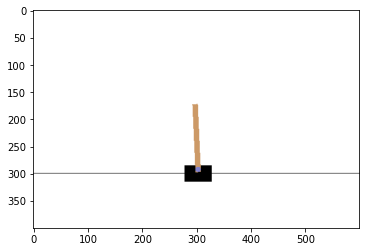

In [3]:
env.reset()
frame = env.render(mode='rgb_array')
plt.imshow(frame)

In [4]:
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
print("CartPole env -- State dimensions: {}, Number of actions: {}".format(num_states,num_actions))

CartPole env -- State dimensions: 4, Number of actions: 2


In [5]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self,env):
        gym.Wrapper.__init__(self,env)
    def reset(self):
        obs = self.env.reset()
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    def step(self,action):
        action = action.item()
        next_state,reward,done,info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1,-1).float()
        done = torch.tensor(done).view(1,-1)
        return next_state,reward,done,info

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state,reward,done,info = env.step(action)
print(f"Sample state:{state}")
print("Next state: {}, Reward: {}, Done: {}".format(next_state,reward,done))

Sample state:tensor([[0.0405, 0.0152, 0.0061, 0.0437]])
Next state: tensor([[ 0.0408, -0.1800,  0.0070,  0.3383]]), Reward: tensor([[1.]]), Done: tensor([[False]])


In [8]:
Q_Net = nn.Sequential(
    nn.Linear(num_states,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,num_actions)
)

In [9]:
target_Q_Net = copy.deepcopy(Q_Net).eval()

In [10]:
def policy(state,epsilon=0.):
    if torch.rand(1) < epsilon:
        action = torch.randint(num_actions,(1,1))
    else:
        av = Q_Net(state).detach()
        action = torch.argmax(av,dim=-1,keepdim=True)
    return action

In [11]:
class ReplayMemory:
    def __init__(self,capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def insert(self,transition):
        if len(self.memory)< self.capacity:
            self.memory.append(None)
        self.memory[self.position]= transition
        self.position = (self.position + 1)%self.capacity
    def sample(self,batch_size):
        assert self.can_sample(batch_size)
        batch = random.sample(self.memory,batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]
    def can_sample(self,batch_size):
        return len(self.memory)>= batch_size*10
    def __len__(self):
        return len(self.memory)

In [12]:
def Deep_Q_Net(Q_Net,policy,epochs,alpha=0.0001,batch_size=32,gamma=0.99,epsilon = 0.2):
    optim = AdamW(Q_Net.parameters(),lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    for epoch in tqdm(range(epochs)):
        state = env.reset()
        done = False
        ep_return = 0
        
        while not done:
            action = policy(state,epsilon)
            next_state,reward,done,_ = env.step(action)
            memory.insert([state,action,reward,done,next_state])
            if memory.can_sample(batch_size):
                state_b,action_b,reward_b,done_b,next_state_b = memory.sample(batch_size)
                qsa_b = Q_Net(state_b).gather(1,action_b)
                next_qsa_b = target_Q_Net(next_state_b)
                next_qsa_b = torch.max(next_qsa_b,dim=-1,keepdim=True)[0]
                target_b = reward_b + ~done_b*gamma*next_qsa_b
                loss = F.mse_loss(qsa_b,target_b)
                
                Q_Net.zero_grad()
                loss.backward()
                optim.step()
                
                stats['MSE Loss'].append(loss)
            state = next_state
            ep_return += reward.item()
        stats['Returns'].append(ep_return)
        
        if epoch % 10 == 0:
            target_Q_Net.load_state_dict(Q_Net.state_dict())
    return stats

In [13]:
stats = Deep_Q_Net(Q_Net,policy,500)

100%|██████████| 500/500 [01:42<00:00,  4.87it/s]


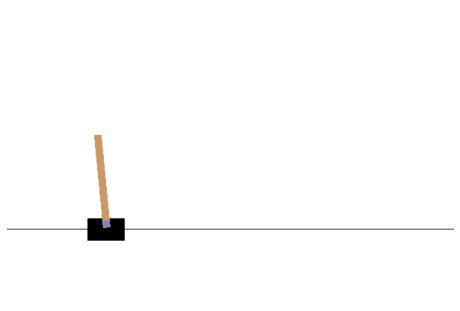

In [14]:
test_agent(env,policy,episodes = 2)

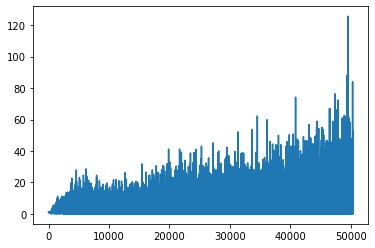

In [15]:
plt.plot(stats['MSE Loss'])
plt.show()

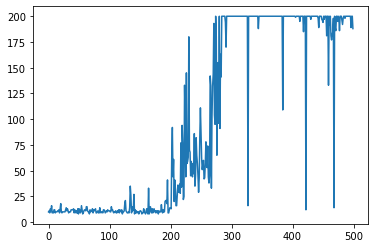

In [16]:
plt.plot(stats['Returns'])